In [113]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [114]:
#change the tickers here according to what's in the portfolio
tickers = ["^TNX","^FVX","TLT"]

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [115]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^TNX    1259 non-null   float64
 1   ^FVX    1259 non-null   float64
 2   TLT     1259 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


## Function that saves dataframe to CSV

In [116]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [117]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [118]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [119]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [120]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [121]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [122]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [123]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [124]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [125]:
#change to the list of stocks we using
port_list = ["^TNX","^FVX","TLT"]

#add in the weightage of stocks
port_shares = [0.33,0.33,0.33]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,^TNX,^FVX,TLT,Total,daily_return
Date,,,,,
2017-01-03,0.80850,0.64152,35.445636,36.895656,NaN
2017-01-04,0.80916,0.64251,35.581919,37.033589,0.003738
2017-01-05,0.78144,0.61479,36.138910,37.535140,0.013543
2017-01-06,0.79794,0.63426,35.807095,37.239295,-0.007882
2017-01-09,0.78408,0.62073,36.094465,37.499275,0.006981
...,...,...,...,...,...
2020-12-24,0.30624,0.12012,50.978630,51.404990,0.003665
2020-12-28,0.30789,0.12012,51.001330,51.429340,0.000474
2020-12-29,0.30855,0.12474,50.936509,51.369799,-0.001158


## Get old data for portfolio

In [126]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,^TNX,^FVX,TLT,Total,daily_return
Date,,,,,
2017-01-03,0.80850,0.64152,35.445636,36.895656,NaN
2017-01-04,0.80916,0.64251,35.581919,37.033589,0.003738
2017-01-05,0.78144,0.61479,36.138910,37.535140,0.013543
2017-01-06,0.79794,0.63426,35.807095,37.239295,-0.007882
2017-01-09,0.78408,0.62073,36.094465,37.499275,0.006981
...,...,...,...,...,...
2020-12-24,0.30624,0.12012,50.978630,51.404990,0.003665
2020-12-28,0.30789,0.12012,51.001330,51.429340,0.000474
2020-12-29,0.30855,0.12474,50.936509,51.369799,-0.001158


## Forecasting

In [127]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [128]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [129]:
tot_port_df

,^TNX,^FVX,TLT,Total,daily_return
Date,,,,,
2017-01-03,0.80850,0.64152,35.445636,36.895656,NaN
2017-01-04,0.80916,0.64251,35.581919,37.033589,0.003738
2017-01-05,0.78144,0.61479,36.138910,37.535140,0.013543
2017-01-06,0.79794,0.63426,35.807095,37.239295,-0.007882
2017-01-07,0.79794,0.63426,35.807095,37.239295,-0.007882
...,...,...,...,...,...
2020-12-27,0.30624,0.12012,50.978630,51.404990,0.003665
2020-12-28,0.30789,0.12012,51.001330,51.429340,0.000474
2020-12-29,0.30855,0.12474,50.936509,51.369799,-0.001158


In [130]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["^TNX","^FVX","TLT", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [131]:
tot_port_df

,Total
Date,
2017-01-03,36.895656
2017-01-04,37.033589
2017-01-05,37.535140
2017-01-06,37.239295
2017-01-07,37.239295
...,...
2020-12-27,51.404990
2020-12-28,51.429340
2020-12-29,51.369799


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2 3 4 5 6 7 8]
Observations : 1459


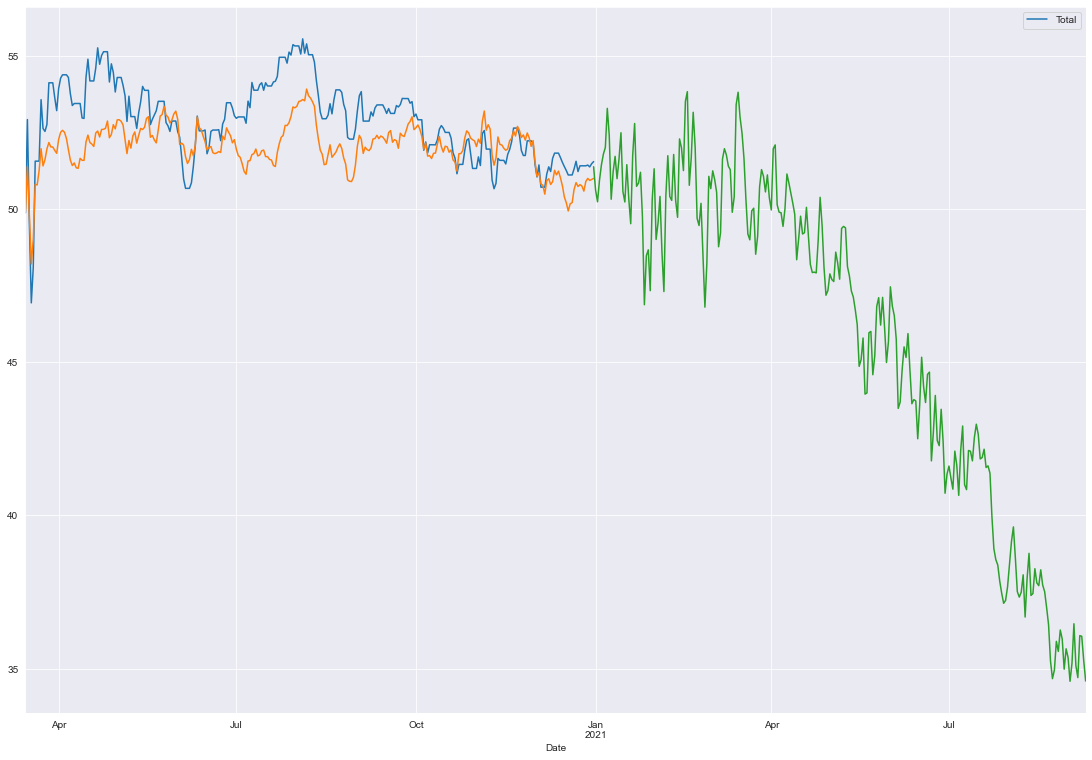

In [132]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80%
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [133]:
forecast

2020-12-31    51.373348
2021-01-01    50.614894
2021-01-02    50.231148
2021-01-03    50.931599
2021-01-04    51.439591
                ...    
2021-09-05    34.708258
2021-09-06    36.076650
2021-09-07    36.056204
2021-09-08    35.272137
2021-09-09    34.597045
Freq: D, Length: 253, dtype: float64

In [134]:
forecast_df = pd.DataFrame(forecast)

In [135]:
forecast_df

,0
2020-12-31,51.373348
2021-01-01,50.614894
2021-01-02,50.231148
2021-01-03,50.931599
2021-01-04,51.439591
...,...
2021-09-05,34.708258
2021-09-06,36.076650
2021-09-07,36.056204
2021-09-08,35.272137


In [136]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [137]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.014764
2021-01-02,-0.022233
2021-01-03,-0.008599
2021-01-04,0.001289
...,...
2021-09-05,-0.324392
2021-09-06,-0.297756
2021-09-07,-0.298154
2021-09-08,-0.313416


In [138]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09 -32.655654


## Backtesting

In [139]:
tickers2 = ["^TNX","^FVX","TLT"]

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [140]:
panel_data2 = panel_data2['Adj Close']

In [141]:
panel_data2

Symbols,^TNX,^FVX,TLT
Date,,,
2020-12-30,0.926,0.370,154.686951
2020-12-31,0.917,0.361,154.912857
2021-01-04,0.917,0.354,154.726227
2021-01-05,0.955,0.377,153.577148
2021-01-06,1.042,0.432,150.424454
...,...,...,...
2021-12-23,1.493,1.243,148.117310
2021-12-27,1.481,1.252,148.476334
2021-12-28,1.481,1.245,147.887924


## Portfolio Analysis

In [142]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,^TNX,^FVX,TLT
Date,,,
2020-12-31,-0.009719,-0.024324,0.001460
2021-01-04,0.000000,-0.019391,-0.001205
2021-01-05,0.041439,0.064972,-0.007427
2021-01-06,0.091100,0.145889,-0.020528
2021-01-07,0.027831,0.050926,-0.008814


In [143]:
portfolio_weights = [0.33,0.33,0.33]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,^TNX,^FVX,TLT
Date,,,
2020-12-31,-0.003207,-0.008027,0.000482
2021-01-04,0.000000,-0.006399,-0.000398
2021-01-05,0.013675,0.021441,-0.002451
2021-01-06,0.030063,0.048143,-0.006774
2021-01-07,0.009184,0.016806,-0.002909


In [144]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.010752
2021-01-04   -0.006796
2021-01-05    0.032665
2021-01-06    0.071432
2021-01-07    0.023081
dtype: float64

Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,86.0%
Cumulative returns,86.0%
Annual volatility,35.8%
Sharpe ratio,1.91
Calmar ratio,4.82
Stability,0.64
Max drawdown,-17.8%


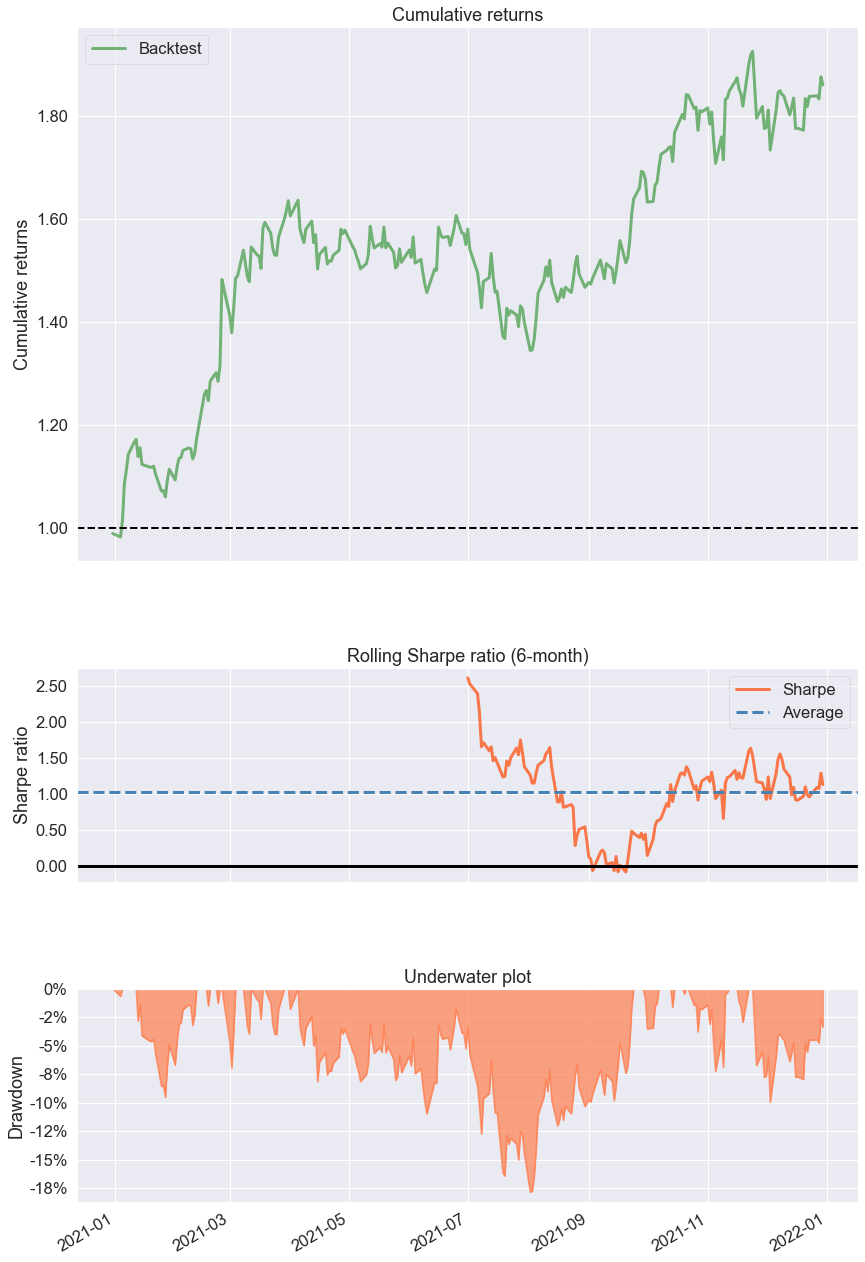

In [145]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [146]:
import itertools

In [147]:
weights = [0.33,0.33,0.33]

In [148]:
panel_data2 = panel_data2 * weights

In [149]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [150]:
#forecasted portfolio value
panel_data2

Symbols,^TNX,^FVX,TLT,Total
Date,,,,
2020-12-30,0.30558,0.12210,51.046694,51.474374
2020-12-31,0.30261,0.11913,51.121243,51.542983
2021-01-04,0.30261,0.11682,51.059655,51.479085
2021-01-05,0.31515,0.12441,50.680459,51.120019
2021-01-06,0.34386,0.14256,49.640070,50.126490
...,...,...,...,...
2021-12-23,0.49269,0.41019,48.878712,49.781592
2021-12-27,0.48873,0.41316,48.997190,49.899080
2021-12-28,0.48873,0.41085,48.803015,49.702595


In [151]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [152]:
actual_portfolio_value

[51.47437372684479,
 51.542982827425,
 51.47908484548331,
 51.12001898020506,
 50.12648975461722,
 49.70578371405602,
 49.566452306807044,
 49.50060262531042,
 49.46532914400101,
 49.99090777337551,
 49.54361444503069,
 49.717951631248,
 49.87311801552773,
 49.92107985019684,
 49.57989173144102,
 49.7284732183814,
 50.28387687832117,
 50.19054106056691,
 50.3067097145319,
 50.053002954125404,
 49.77099164754153,
 49.8165531501174,
 49.514727542996404,
 49.093115690946576,
 48.96596825122833,
 48.57324175715446,
 48.78349453657866,
 48.817875522673134,
 49.125248911678796,
 48.8690733101964,
 48.29055807709694,
 47.62146815657616,
 47.92231192946434,
 47.72029087901116,
 47.124083265066155,
 46.78392674446106,
 46.64230642318726,
 46.360344969034195,
 45.719303153157234,
 47.17771110534668,
 46.53827896535397,
 46.51942685902119,
 46.05767236232758,
 45.80983678042889,
 45.89986348450184,
 45.58431683421135,
 46.17875419020653,
 46.251568695902826,
 45.921131855249406,
 45.0211641848087

In [153]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [154]:
forecasted_portfolio_value

[51.3733478588938,
 50.61489390997096,
 50.23114758132738,
 50.93159936134984,
 51.43959103946177,
 51.786125017254456,
 52.002245227284526,
 53.27887078056927,
 52.39927387085251,
 50.314296445262464,
 51.21193979867907,
 51.71335104680512,
 50.98519099215745,
 51.61732872990154,
 52.48343045011555,
 50.564247604944825,
 50.22474843270682,
 51.442610478553306,
 50.32993895964659,
 49.51582981250852,
 51.732479301943386,
 52.78479976199151,
 50.73603718009085,
 50.84155882683439,
 51.19352653377109,
 49.735818396017855,
 46.872249796799586,
 48.471214693222855,
 48.6632738436666,
 47.33125037863448,
 50.29277247854109,
 51.30830117366901,
 49.00341272663269,
 49.543063410521725,
 50.406476350466164,
 48.583778684642105,
 47.302186858365374,
 50.43346013343384,
 51.73496439966701,
 50.40320615108664,
 50.27734569674108,
 51.77451940169771,
 50.279585462852886,
 49.72482137375951,
 52.28219601435904,
 51.99371645066569,
 51.24906089564933,
 53.5032274341999,
 53.82438880469901,
 50.76919

## Calculate MAPE of forecasted period

In [155]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.12
MAPE % : 11.68 %



## Mean Squared Error

In [156]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

48.859178360004975


## Forecast for future

In [157]:
#change to the list of stocks we using
port_list = ["^TNX","^FVX","TLT"]

#add in the weightage of stocks
port_shares = [0.33,0.33,0.33]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,^TNX,^FVX,TLT,Total,daily_return
Date,,,,,
2017-01-03,0.80850,0.64152,35.445636,36.895656,NaN
2017-01-04,0.80916,0.64251,35.581919,37.033589,0.003738
2017-01-05,0.78144,0.61479,36.138910,37.535140,0.013543
2017-01-06,0.79794,0.63426,35.807095,37.239295,-0.007882
2017-01-09,0.78408,0.62073,36.094465,37.499275,0.006981
...,...,...,...,...,...
2021-12-27,0.48873,0.41316,48.997190,49.899080,0.002360
2021-12-28,0.48873,0.41085,48.803015,49.702595,-0.003938
2021-12-29,0.50919,0.42702,48.269867,49.206077,-0.009990


In [158]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,^TNX,^FVX,TLT,Total,daily_return
Date,,,,,
2017-01-03,0.80850,0.64152,35.445636,36.895656,NaN
2017-01-04,0.80916,0.64251,35.581919,37.033589,0.003738
2017-01-05,0.78144,0.61479,36.138910,37.535140,0.013543
2017-01-06,0.79794,0.63426,35.807095,37.239295,-0.007882
2017-01-09,0.78408,0.62073,36.094465,37.499275,0.006981
...,...,...,...,...,...
2021-12-27,0.48873,0.41316,48.997190,49.899080,0.002360
2021-12-28,0.48873,0.41085,48.803015,49.702595,-0.003938
2021-12-29,0.50919,0.42702,48.269867,49.206077,-0.009990


In [159]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [160]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [161]:
tot_port_df

,^TNX,^FVX,TLT,Total,daily_return
Date,,,,,
2017-01-03,0.80850,0.64152,35.445636,36.895656,NaN
2017-01-04,0.80916,0.64251,35.581919,37.033589,0.003738
2017-01-05,0.78144,0.61479,36.138910,37.535140,0.013543
2017-01-06,0.79794,0.63426,35.807095,37.239295,-0.007882
2017-01-07,0.79794,0.63426,35.807095,37.239295,-0.007882
...,...,...,...,...,...
2021-12-27,0.48873,0.41316,48.997190,49.899080,0.002360
2021-12-28,0.48873,0.41085,48.803015,49.702595,-0.003938
2021-12-29,0.50919,0.42702,48.269867,49.206077,-0.009990


In [162]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["^TNX","^FVX","TLT", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [163]:
tot_port_df

,Total
Date,
2017-01-03,36.895656
2017-01-04,37.033589
2017-01-05,37.535140
2017-01-06,37.239295
2017-01-07,37.239295
...,...
2021-12-27,49.899080
2021-12-28,49.702595
2021-12-29,49.206077


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2 3 4 5 6 7 8]
Observations : 1824


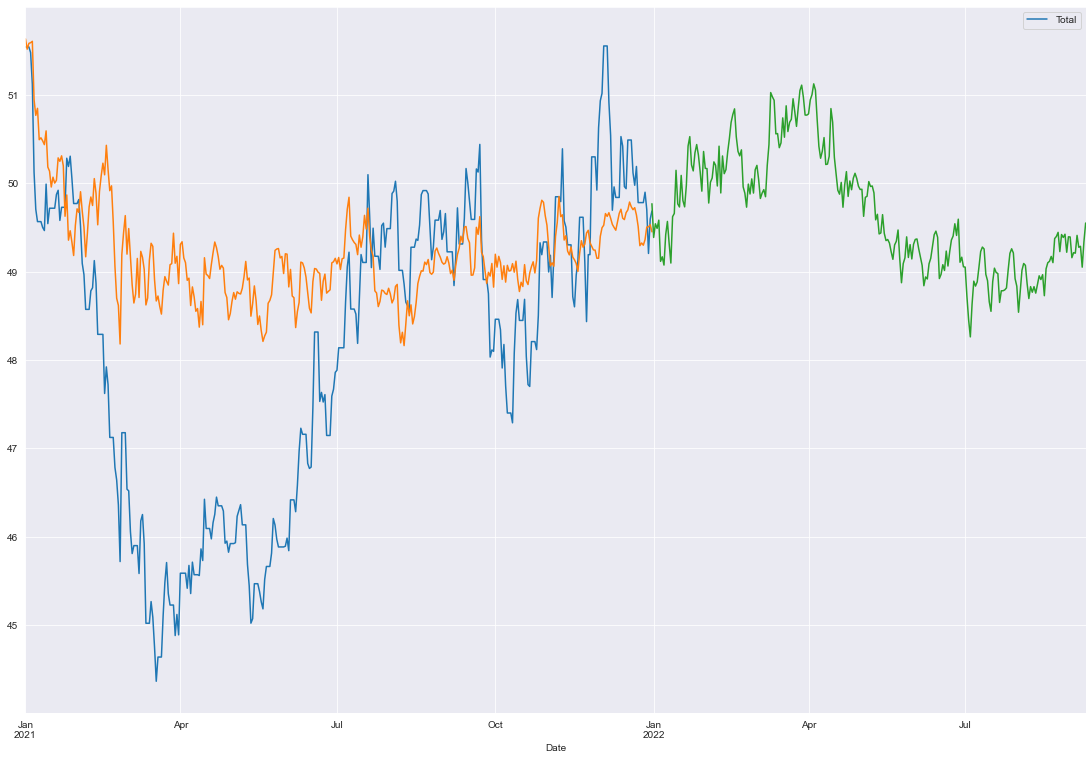

In [164]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [165]:
## Calculate annualized returns for forecasted

In [166]:
forecast

2021-12-31    49.769003
2022-01-01    49.387221
2022-01-02    49.541919
2022-01-03    49.489891
2022-01-04    49.582860
                ...    
2022-09-05    49.276004
2022-09-06    49.286856
2022-09-07    49.050927
2022-09-08    49.338827
2022-09-09    49.550471
Freq: D, Length: 253, dtype: float64

In [167]:
forecast_df = pd.DataFrame(forecast)

In [168]:
forecast_df

,0
2021-12-31,49.769003
2022-01-01,49.387221
2022-01-02,49.541919
2022-01-03,49.489891
2022-01-04,49.582860
...,...
2022-09-05,49.276004
2022-09-06,49.286856
2022-09-07,49.050927
2022-09-08,49.338827


In [169]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [170]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.007671
2022-01-02,-0.004563
2022-01-03,-0.005608
2022-01-04,-0.003740
...,...
2022-09-05,-0.009906
2022-09-06,-0.009688
2022-09-07,-0.014428
2022-09-08,-0.008643


In [171]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                   0
2022-09-09 -0.439093
